In [1]:
import datetime as dt

import happybase
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
def load_hbase_to_df(table_name, host="localhost", port=9090):
    connection  = happybase.Connection(host, port)
    table = connection .table(table_name)
    rows = table.scan()
    data = [{k.decode().split(' ')[-1]: v.decode() for k, v in row[1].items()} for row in rows]
    connection.close()
    df = pd.DataFrame(data)
    return df

In [3]:
df_day = load_hbase_to_df("aggregated_type_day")
df_hour = load_hbase_to_df("aggregated_type_hour")

In [4]:
df_day.head()

,type,day,count,max_temp,max_humidity,max_windgust,max_pressure,max_visibility,min_temp,min_humidity,min_windgust,min_pressure,min_visibility,avg_temp,avg_humidity,avg_windgust,avg_pressure,avg_visibility
0,Brush Fire,2022-12-03,1,1.9,71.13,23.0,1020.1,16.0,1.9,71.13,23.0,1020.1,16.0,1.900000,71.130000,23.000000,1020.100000,16.000000
1,MVI - Motor Vehicle Incident,2022-12-05,4,4.2,88.22,11.9,1018.5,16.0,3.0,86.79,7.2,1016.9,14.8,3.425000,87.317500,9.550000,1017.700000,15.600000
2,1RED 1 Unit,2022-12-07,7,6.8,94.67,20.9,1021.9,16.0,4.0,66.50,13.0,1016.5,14.1,5.371429,82.198571,16.528571,1019.742857,15.357143
3,Unk Odor,2022-12-18,1,1.9,81.38,14.8,1015.1,15.7,1.9,81.38,14.8,1015.1,15.7,1.900000,81.380000,14.800000,1015.100000,15.700000
4,Automatic Fire Alarm False,2022-12-20,4,2.1,97.16,31.7,1022.9,10.6,-0.9,87.14,7.9,1017.6,1.0,0.025000,92.760000,17.750000,1019.500000,7.000000


In [5]:
df_hour.head()

,type,hour,count
0,Rescue Lock In/Out,16:00:00,3
1,Aid Response Yellow,08:00:00,3
2,AFA4 - Auto Alarm 2 + 1 + 1,03:00:00,2
3,Illegal Burn,05:00:00,14
4,Crisis Center,18:00:00,2


In [6]:
aggregated_hour = df_hour.groupby(['hour'])['count'].agg('sum').reset_index()
aggregated_day = df_day.groupby(['day'])['count'].agg('sum').reset_index()

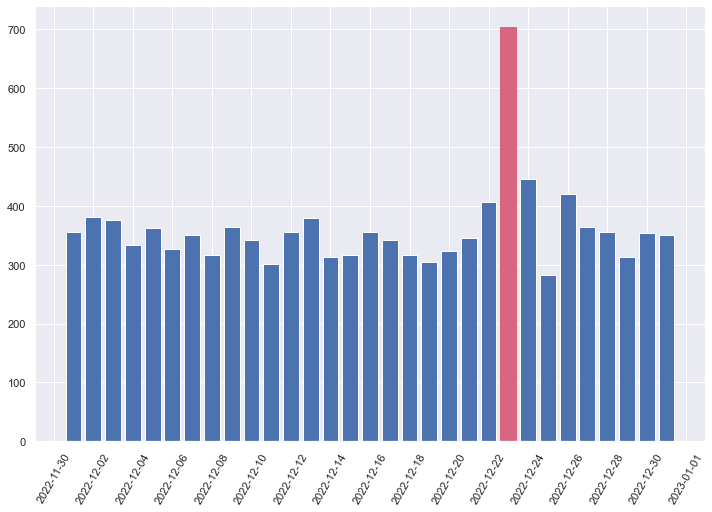

In [7]:
x = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in aggregated_day["day"]]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
bars = ax.bar(x, aggregated_day["count"])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
bars[22].set_color((0.85, 0.40, 0.50))
ax.tick_params(axis='x', labelrotation=60)


In [8]:
def what_time_of_the_day(hour):
    hour = int(hour)
    if hour < 6:
        return "night"
    elif hour < 12:
        return "morning"
    elif hour < 18:
        return "afternoon"
    else:
        return "evening"


df_hour['time_of_day'] = df_hour['hour'].apply(lambda x: what_time_of_the_day(x.split(':')[0]))

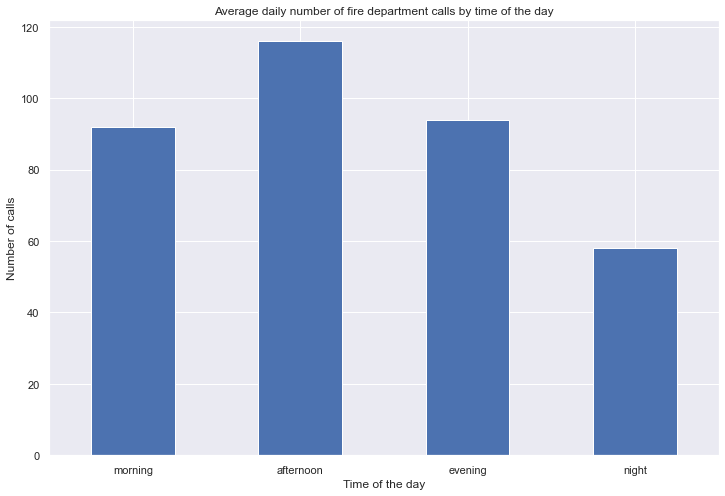

In [9]:
agg_time_of_day = df_hour.groupby(['time_of_day'])['count'].agg('sum').reset_index()
agg_time_of_day = agg_time_of_day.set_index("time_of_day").reindex(['morning', 'afternoon', 'evening', 'night'])
agg_time_of_day = round(agg_time_of_day / 31, 0)
plot = agg_time_of_day.plot.bar(rot=0,
                                title="Average daily number of fire department calls by time of the day",
                                legend=False,
                                figsize=(12, 8),
                                xlabel="Time of the day",
                                ylabel="Number of calls")


In [10]:
### Pogoda

calls_temp = df_hour.groupby(['hour'])['count'].agg('sum').reset_index()

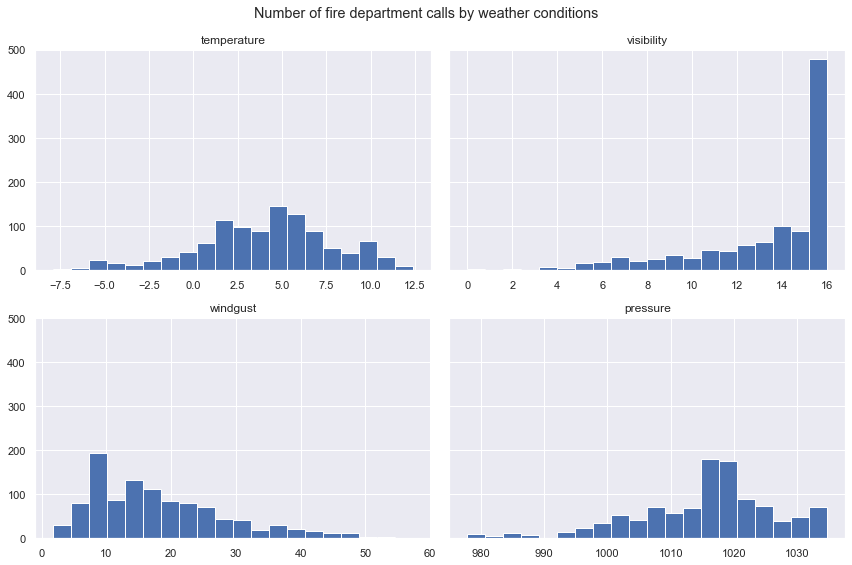

In [11]:
fig, axs = plt.subplots(
    2,
    2,
    sharey=True,
    tight_layout=True,
    figsize=(12, 8),
)
axs[0][0].hist(df_day["avg_temp"], bins=20)
axs[0][0].set_title("temperature")
axs[0][1].hist(df_day["avg_visibility"], bins=20)
axs[0][1].set_title("visibility")
axs[1][0].hist(df_day["avg_windgust"], bins=20)
axs[1][0].set_title("windgust")
axs[1][1].hist(df_day["avg_pressure"], bins=20)
axs[1][1].set_title("pressure")
fig.suptitle("Number of fire department calls by weather conditions")
plt.show()

In [12]:
df_day.columns

Index(['type', 'day', 'count', 'max_temp', 'max_humidity', 'max_windgust',
       'max_pressure', 'max_visibility', 'min_temp', 'min_humidity',
       'min_windgust', 'min_pressure', 'min_visibility', 'avg_temp',
       'avg_humidity', 'avg_windgust', 'avg_pressure', 'avg_visibility'],
      dtype='object')

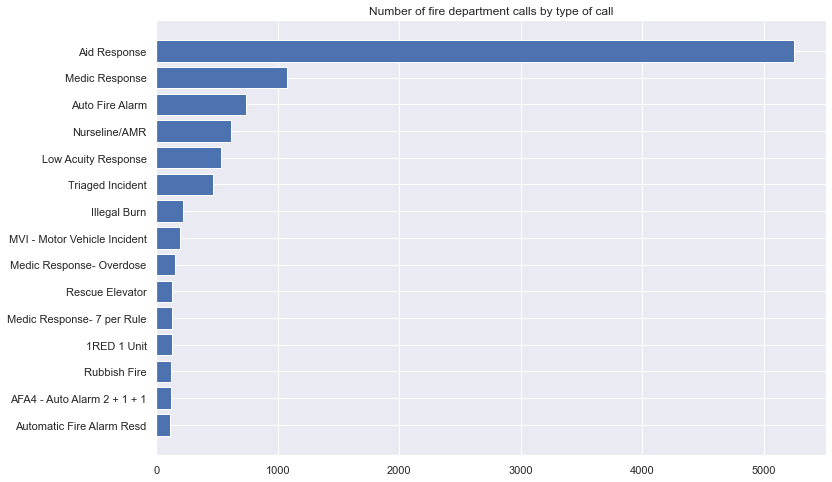

In [13]:
agg_type = df_day.groupby(['type']).agg({
    "count": "sum",
    "avg_temp": "mean",
    "avg_humidity": "mean",
    "avg_windgust": "mean",
    "avg_pressure": "mean",
    "avg_visibility": "mean"
}).reset_index()

agg_type = agg_type.sort_values(by=['count'], ascending=False)
agg_type_head = agg_type.head(15).sort_values(by=['count'], ascending=True)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
ax.barh(agg_type_head["type"], agg_type_head["count"])
ax.tick_params(axis='x')
ax.set_title("Number of fire department calls by type of call")
plt.show()

In [14]:
selected_types = [
    "Rubbish Fire", "MVI - Motor Vehicle Incident", "Illegal Burn", "Auto Fire Alarm", "Automatic Fire Alarm Resd",
    "Rescue Elevator"
]


In [15]:
selected_types_agg = df_day.loc[df_day["type"].isin(selected_types), :]
selected_types_agg['normalized count'] = selected_types_agg['count'].div(
    selected_types_agg.groupby('type')['count'].transform('sum'))


C:\Users\artur\AppData\Local\Temp/ipykernel_15584/1307244848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_types_agg['normalized count'] = selected_types_agg['count'].div(


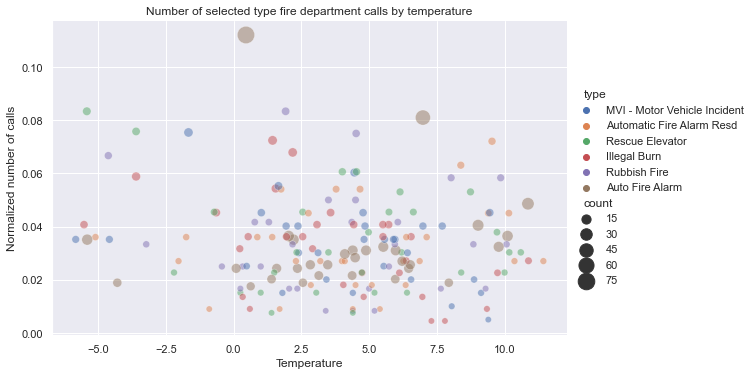

In [16]:
ax = sns.relplot(data=selected_types_agg,
                 x='avg_temp',
                 y='normalized count',
                 hue='type',
                 aspect=1.61,
                 size='count',
                 sizes=(40, 300),
                 alpha=0.5).set(title="Number of selected type fire department calls by temperature")
sns.set(rc={'figure.figsize': (12, 8)})
ax.set(xlabel="Temperature", ylabel="Normalized number of calls")
plt.show()

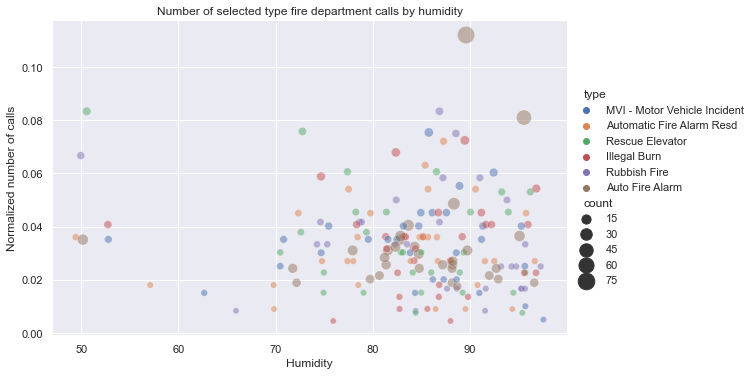

In [17]:
ax = sns.relplot(data=selected_types_agg,
                 x='avg_humidity',
                 y='normalized count',
                 hue='type',
                 aspect=1.61,
                 size='count',
                 sizes=(40, 300),
                 alpha=0.5).set(title="Number of selected type fire department calls by humidity")
ax.set(xlabel="Humidity", ylabel="Normalized number of calls")
plt.show()